In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
from HST_extraction import WavelengthSolution

['/home/mmmurphy/inquiry/hd219666b/reduction', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/mmmurphy/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/mmmurphy/anaconda3/lib/python3.8/site-packages']


In this notebook, I would like to turn the full set of 1D spectra and broadband values into spectral-binned time series. 

Loading in the reduced data, containing the 1D spectra and broadband flux values for each image of each orbit of each visit 3, that I produced in the 'HST Image Reduction' notebook.

In [2]:
# Loading in 1D spectra from each orbit in visit 3
datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
o1data = np.load(datapath+'orbit1_extractedrawdata.npz')
time_o1 = o1data['times']             # times in [bjd tdb]
spec_o1 = o1data['spectra1D']         # un-normalized 1D spectrum
errs_o1 = o1data['errs1D']            # photon noise uncertainty on above
lims_o1 = o1data['spectral_xlimits']  # min and max x- value of the spectrum on whole detector axis
disp_o1 = np.arange(len(spec_o1[0]))  # cut-out pixel axis
o2data = np.load(datapath+'orbit2_extractedrawdata.npz')
time_o2 = o2data['times']
spec_o2 = o2data['spectra1D']
errs_o2 = o2data['errs1D']
lims_o2 = o2data['spectral_xlimits']
disp_o2 = np.arange(len(spec_o2[0]))
o3data = np.load(datapath+'orbit3_extractedrawdata.npz')
time_o3 = o3data['times']
spec_o3 = o3data['spectra1D']
errs_o3 = o3data['errs1D']
lims_o3 = o3data['spectral_xlimits']
disp_o3 = np.arange(len(spec_o3[0]))
o4data = np.load(datapath+'orbit4_extractedrawdata.npz')
time_o4 = o4data['times']
spec_o4 = o4data['spectra1D']
errs_o4 = o4data['errs1D']
lims_o4 = o4data['spectral_xlimits']
disp_o4 = np.arange(len(spec_o4[0]))

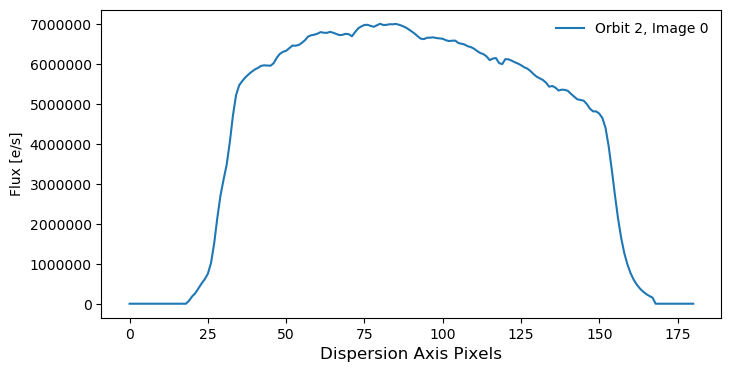

In [3]:
# Plotting an example spectrum, since I like thinking with visuals
plt.figure(figsize=(8,4))
plt.plot(disp_o2, spec_o2[0], label='Orbit 2, Image 0')
plt.xlabel('Dispersion Axis Pixels', fontsize=12)
plt.ylabel('Flux [e/s]')
plt.legend(loc='upper right', frameon=False)
plt.show()

First, I need to find the wavelength calibration in order to transform the dispersion axis from pixels to physical wavelength. I'll do this using a model stellar spectrum as my calibrator. Since the observed spectrum is dominated by the spectrum of the host star, I can align them by picking out notable stellar absorption features. 

HD 219666 is a G7 dwarf star with $T_{eff} = 5527 K$, $log g = 4.38$ in cm/$s^2$, and zero metallicity. I think this is luminosity class V.



The closest thing I can find is a sample G8V star spectrum from https://www.eso.org/sci/facilities/paranal/decommissioned/isaac/tools/lib.html. 

In [4]:
# Opening up the stellar spectrum, which is saved as a fits file
stellarspectrum_file = '/home/mmmurphy/data/hd219666b/calibrations/ukg8v.fits'
ssHDU = fits.open(stellarspectrum_file)
# The fits file stores only the flux
stellarspectrum_flux = ssHDU[0].data
# The corresponding wavelengths are pre-specified
#     Between 1,150 and 25,000 angstroms in uniform 5 angstrom steps
stellarspectrum_wavs = np.arange(1150, 25000+5, 5)   # [Angstrom]

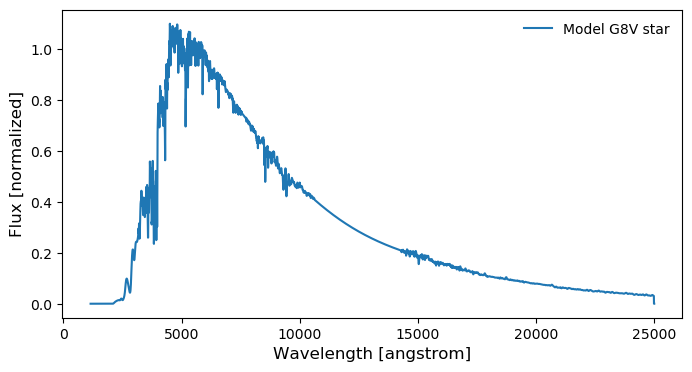

In [5]:
# Looking at the stellar spectrum
plt.figure(figsize=(8,4))
plt.plot(stellarspectrum_wavs, stellarspectrum_flux,
        label='Model G8V star')
plt.xlabel('Wavelength [angstrom]', fontsize=12)
plt.ylabel('Flux [normalized]', fontsize=12)
plt.legend(loc='upper right', frameon=False)
plt.show()

I'm unsure what this spectrum is normalized with respect to, but it doesn't matter for me since I don't need the amplitudes of this model spectrum. I only need the wavelength information. 

Let's crop this down to the WFC3 wavelength range.

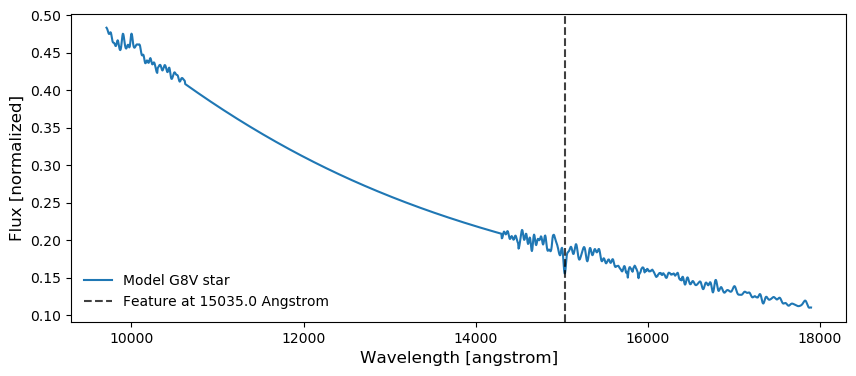

In [6]:
wfc_minwav = 9708 #11250  # [angstrom]
wfc_maxwav = 17904 #16500  # [angstrom]
star_wfc_idxs = np.where((stellarspectrum_wavs >= wfc_minwav) & 
                        (stellarspectrum_wavs <= wfc_maxwav))[0]

# Cropping the spectrum
starwavs = stellarspectrum_wavs[star_wfc_idxs]
starflux = stellarspectrum_flux[star_wfc_idxs]

# In anticipation of what I know I'll see below,
#   finding the array index of the absorption feature near 15,000 angstrom
nearfeature_idxs = np.where((starwavs >= 15000) & (starwavs <= 15100))[0]
nearfeature_fluxes = starflux[nearfeature_idxs]
feature_idx = np.where(nearfeature_fluxes == min(nearfeature_fluxes))[0][0] + nearfeature_idxs[0]
feature_wav = starwavs[feature_idx]  # [angstrom]

# Now plotting the cropped spectrum
plt.figure(figsize=(10,4))
plt.plot(starwavs, starflux, label='Model G8V star')
plt.axvline(feature_wav, ls='--', c='black', alpha=0.75, label='Feature at %.1f Angstrom'%(feature_wav))
plt.xlabel('Wavelength [angstrom]', fontsize=12)
plt.ylabel('Flux [normalized]', fontsize=12)
plt.legend(loc='lower left', frameon=False)
plt.show()

There's a notable feature around 15,035 angstroms that should suffice for calibrating the spectra. Now to try finding it in the observed spectrum.

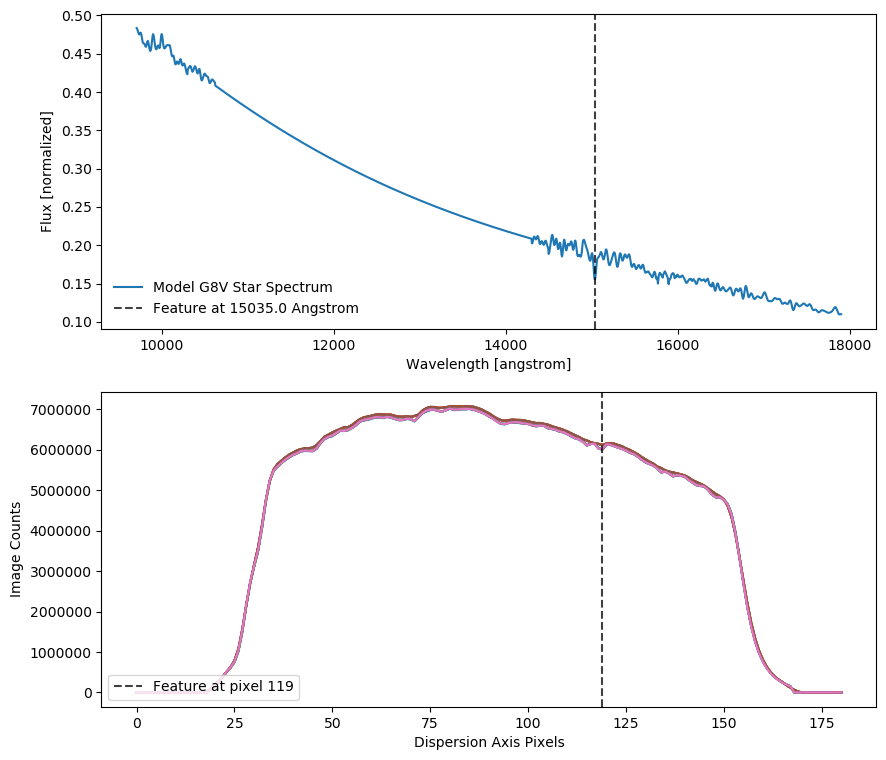

In [7]:
# First plotting the stellar spectrum and feature for comparison
fig, ax = plt.subplots(figsize=(10,9), nrows=2)
ax[0].plot(starwavs, starflux, label='Model G8V Star Spectrum')
ax[0].axvline(feature_wav, ls='--', c='black', alpha=0.75, label='Feature at %.1f Angstrom'%(feature_wav))
ax[0].set_xlabel('Wavelength [angstrom]')
ax[0].set_ylabel('Flux [normalized]')
ax[0].legend(loc='lower left', frameon=False)

# I think I see the feature between pixels 90 and 95 in the observed data
obsnearfeature_fluxes = spec_o2[0][100:120]
feature_pixel = np.where(obsnearfeature_fluxes == min(obsnearfeature_fluxes))[0][0] + 100

for img in range(spec_o2.shape[0]):
    ax[1].plot(disp_o2, spec_o2[img] )
ax[1].axvline(feature_pixel, ls='--', c='black', alpha=0.75, label='Feature at pixel %d'%(feature_pixel))
#ax[1].set_ylim(4.e6)
ax[1].set_xlabel('Dispersion Axis Pixels')
ax[1].set_ylabel('Image Counts')
ax[1].legend(loc='lower left', frameon=True)
plt.show()

Let's also look into the wavelength solution done in my extraction functions

In [8]:
o1directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz205j2q_ima.fits'
o2directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz206jvq_ima.fits'
o3directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz207koq_ima.fits'
o4directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz208lhq_ima.fits'
wsparams_o1 = WavelengthSolution(o1directimg)
wsparams_o2 = WavelengthSolution(o2directimg)
wsparams_o3 = WavelengthSolution(o3directimg)
wsparams_o4 = WavelengthSolution(o4directimg)
full_dispaxis = np.arange(522.0)
waveFunc_o1 = wsparams_o1[0] + wsparams_o1[1]*(full_dispaxis - wsparams_o1[2])
waveFunc_o2 = wsparams_o2[0] + wsparams_o2[1]*(full_dispaxis - wsparams_o2[2])
waveFunc_o3 = wsparams_o3[0] + wsparams_o3[1]*(full_dispaxis - wsparams_o3[2])
waveFunc_o4 = wsparams_o4[0] + wsparams_o4[1]*(full_dispaxis - wsparams_o4[2])

# I believe that waveInterp(wavelength in angstrom) returns the pixel value for that wavelength
waveInterp_o1 = interp1d(waveFunc_o1, full_dispaxis, kind='linear')
waveInterp_o2 = interp1d(waveFunc_o2, full_dispaxis, kind='linear')
waveInterp_o3 = interp1d(waveFunc_o3, full_dispaxis, kind='linear')
waveInterp_o4 = interp1d(waveFunc_o4, full_dispaxis, kind='linear')

fullpixs_o1 = np.arange(lims_o1[0][0], lims_o1[0][1], 1)
fullpixs_o2 = np.arange(lims_o2[0][0], lims_o2[0][1], 1)
fullpixs_o3 = np.arange(lims_o3[0][0], lims_o3[0][1], 1)
fullpixs_o4 = np.arange(lims_o4[0][0], lims_o4[0][1], 1)

I know the pixels. I have a function which returns the pixel for a corresponding wavelength. I need to combine these to get a function which returns the wavelength for a corresponding pixel. Luckily, the wavelength solution function is linear, so I can just reverse engineer it.

In [9]:
temp_wavs = np.linspace(9000, 18000, 500)   # wide range that encompasses the WFC3/G141 wavelength range
temp_pixs_o1 = waveInterp_o1(temp_wavs)
temp_pixs_o2 = waveInterp_o2(temp_wavs)
temp_pixs_o3 = waveInterp_o3(temp_wavs)
temp_pixs_o4 = waveInterp_o4(temp_wavs)

# fit line with x = pixs and y = wavs; y = mx + b
m1, b1 = np.polyfit(x=temp_pixs_o1, y=temp_wavs, deg=1)
m2, b2 = np.polyfit(x=temp_pixs_o2, y=temp_wavs, deg=1)
m3, b3 = np.polyfit(x=temp_pixs_o3, y=temp_wavs, deg=1)
m4, b4 = np.polyfit(x=temp_pixs_o4, y=temp_wavs, deg=1)

# now re-solve
wavs_o1 = m1*fullpixs_o1 + b1
wavs_o2 = m1*fullpixs_o2 + b2
wavs_o3 = m1*fullpixs_o3 + b3
wavs_o4 = m1*fullpixs_o4 + b4

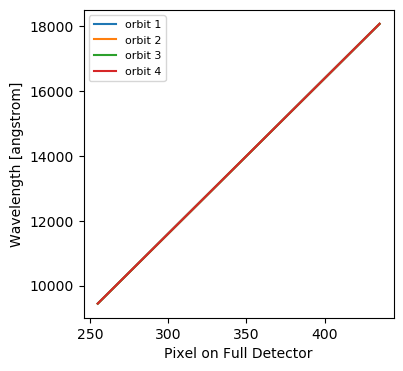

In [10]:
# Plotting the wavelength calibration
plt.figure(figsize=(4,4))
plt.plot(fullpixs_o1, wavs_o1, label='orbit 1')
plt.plot(fullpixs_o2, wavs_o2, label='orbit 2')
plt.plot(fullpixs_o3, wavs_o3, label='orbit 3')
plt.plot(fullpixs_o4, wavs_o4, label='orbit 4')
plt.xlabel('Pixel on Full Detector')
plt.ylabel('Wavelength [angstrom]')
plt.legend(loc='best', fontsize=8)
plt.show()

Let's compare this to the stellar spectrum as a comparison

No handles with labels found to put in legend.


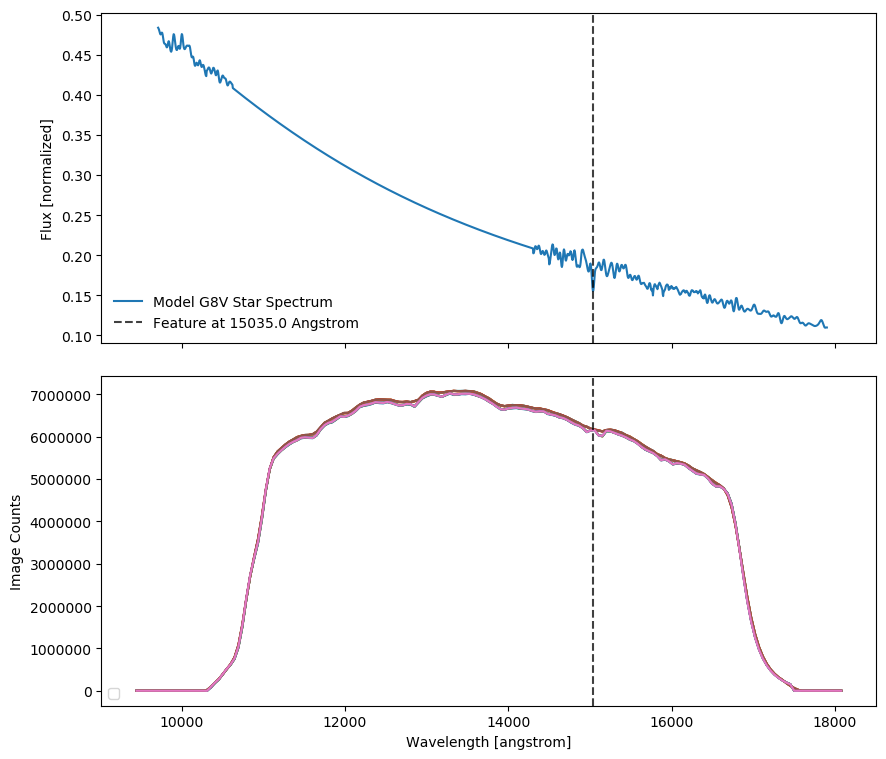

In [11]:
# First plotting the stellar spectrum and feature for comparison
fig, ax = plt.subplots(figsize=(10,9), nrows=2, sharex=True)
plt.subplots_adjust(hspace=0.1)
ax[0].plot(starwavs, starflux, label='Model G8V Star Spectrum')
ax[0].axvline(feature_wav, ls='--', c='black', alpha=0.75, label='Feature at %.1f Angstrom'%(feature_wav))
#ax[0].set_xlabel('Wavelength [angstrom]')
ax[0].set_ylabel('Flux [normalized]')
ax[0].legend(loc='lower left', frameon=False)

# # I think I see the feature between pixels 90 and 95 in the observed data
# obsnearfeature_fluxes = spec_o2[0][100:120]
# feature_pixel = np.where(obsnearfeature_fluxes == min(obsnearfeature_fluxes))[0][0] + 100

for img in range(spec_o2.shape[0]):
    ax[1].plot(wavs_o2, spec_o2[img] )
ax[1].axvline(feature_wav, ls='--', c='black', alpha=0.75)
#ax[1].set_ylim(4.e6)
ax[1].set_xlabel('Wavelength [angstrom]')
ax[1].set_ylabel('Image Counts')
ax[1].legend(loc='lower left', frameon=True)
plt.show()

Looks like the feature in the stellar spectrum doesn't exactly line up with the absorption features in the observed spectrum, which is telling of something. I trust the wavelength solution more.

Now onto the binning

In [12]:
def binspectrum(x_axis, spectrum, specerrors, Nbins):
    
    bin_edges = np.linspace(x_axis[0], x_axis[-1], Nbins, endpoint=True)
    #print(bin_edges)
    bin_identities = np.digitize(x_axis, bin_edges) - 1
    #print(bin_identities)
    
    spectrum_binned = np.zeros(Nbins)
    specerrs_binned = np.zeros(Nbins)
    bin_midxs = np.zeros(Nbins) 
    i = 0
    while i <= (Nbins - 1):
        bin_member_idxs = np.where(bin_identities == i)[0]
        member_specvals = spectrum[bin_member_idxs]
        member_errsvals = specerrors[bin_member_idxs]
        
        bin_specval = np.median(member_specvals)
        bin_errsval = np.median(member_errsvals) / np.sqrt(len(member_errsvals))
        spectrum_binned[i] = bin_specval
        specerrs_binned[i] = bin_errsval
        
        try:
            # works until i = Nbins
            bin_midxs[i] = np.median([bin_edges[i], bin_edges[i+1]])
        except IndexError:
            bin_width = abs(bin_edges[2] - bin_edges[1])
            bin_midxs[i] = np.median([bin_edges[i], bin_edges[i]+bin_width])
        
        i += 1
    
    return bin_midxs, spectrum_binned, specerrs_binned

In [13]:
# Defining the number of bins to use
Nbins = 16
# We extracted more wavelengths than are to be used, as the edges go over the filter's response
#   so we need to slightly trim our spectra
G141_minwav = 12000. #11250.
G141_maxwav = 16000. #16500.
o1_goodwav_idxs = np.where((wavs_o1 >= G141_minwav) & (wavs_o1 <= G141_maxwav))[0]
o2_goodwav_idxs = np.where((wavs_o2 >= G141_minwav) & (wavs_o2 <= G141_maxwav))[0]
o3_goodwav_idxs = np.where((wavs_o3 >= G141_minwav) & (wavs_o3 <= G141_maxwav))[0]
o4_goodwav_idxs = np.where((wavs_o4 >= G141_minwav) & (wavs_o4 <= G141_maxwav))[0]

waves_o1 = wavs_o1[o1_goodwav_idxs]
waves_o2 = wavs_o2[o2_goodwav_idxs]
waves_o3 = wavs_o3[o3_goodwav_idxs]
waves_o4 = wavs_o4[o4_goodwav_idxs]

trimmed_spec_o1, trimmed_errs_o1 = np.zeros((spec_o1.shape[0], len(waves_o1))), np.zeros((spec_o1.shape[0], len(waves_o1)))
trimmed_spec_o2, trimmed_errs_o2 = np.zeros((spec_o2.shape[0], len(waves_o2))), np.zeros((spec_o2.shape[0], len(waves_o2)))
trimmed_spec_o3, trimmed_errs_o3 = np.zeros((spec_o3.shape[0], len(waves_o3))), np.zeros((spec_o3.shape[0], len(waves_o3)))
trimmed_spec_o4, trimmed_errs_o4 = np.zeros((spec_o4.shape[0], len(waves_o4))), np.zeros((spec_o4.shape[0], len(waves_o4)))

for img in range(spec_o1.shape[0]):
    # luckily, each orbit has the same number of images so i only need to do one loop
    trimmed_spec_o1[img], trimmed_errs_o1[img] = spec_o1[img][o1_goodwav_idxs], errs_o1[img][o1_goodwav_idxs]
    trimmed_spec_o2[img], trimmed_errs_o2[img] = spec_o2[img][o2_goodwav_idxs], errs_o2[img][o2_goodwav_idxs]
    trimmed_spec_o3[img], trimmed_errs_o3[img] = spec_o3[img][o3_goodwav_idxs], errs_o3[img][o3_goodwav_idxs]
    trimmed_spec_o4[img], trimmed_errs_o4[img] = spec_o4[img][o4_goodwav_idxs], errs_o4[img][o4_goodwav_idxs]
    
Nimages = spec_o1.shape[0]
binnedspec_o1, binnederrs_o1 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o2, binnederrs_o2 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o3, binnederrs_o3 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o4, binnederrs_o4 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
for img in range(Nimages):
    binnedwavs_o1, binnedspec_o1[img], binnederrs_o1[img] = binspectrum(waves_o1, trimmed_spec_o1[img], trimmed_errs_o1[img], Nbins)
    binnedwavs_o2, binnedspec_o2[img], binnederrs_o2[img] = binspectrum(waves_o2, trimmed_spec_o2[img], trimmed_errs_o2[img], Nbins)
    binnedwavs_o3, binnedspec_o3[img], binnederrs_o3[img] = binspectrum(waves_o3, trimmed_spec_o3[img], trimmed_errs_o3[img], Nbins)
    binnedwavs_o4, binnedspec_o4[img], binnederrs_o4[img] = binspectrum(waves_o4, trimmed_spec_o4[img], trimmed_errs_o4[img], Nbins)
    ### need to figure out errors too

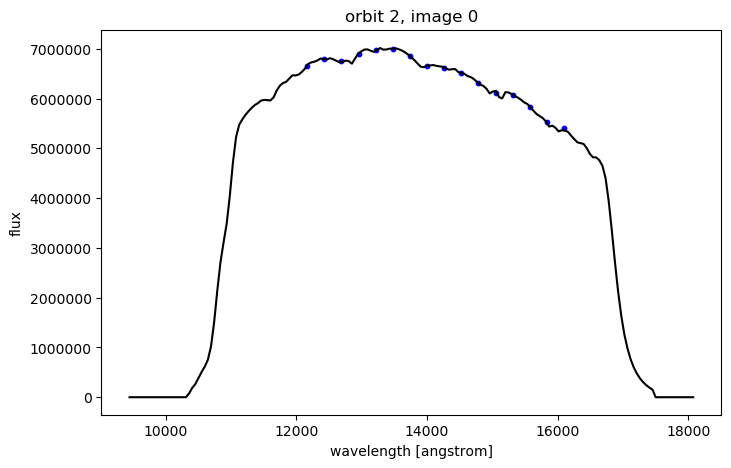

In [14]:
plt.figure(figsize=(8,5))
plt.plot(wavs_o2, spec_o2[0], c='black', label='full 1D spectrum')
plt.scatter(binnedwavs_o2, binnedspec_o2[0], c='blue', s=10, label='binned spectrum')
plt.title('orbit 2, image 0')
plt.xlabel('wavelength [angstrom]')
plt.ylabel('flux')
plt.show()

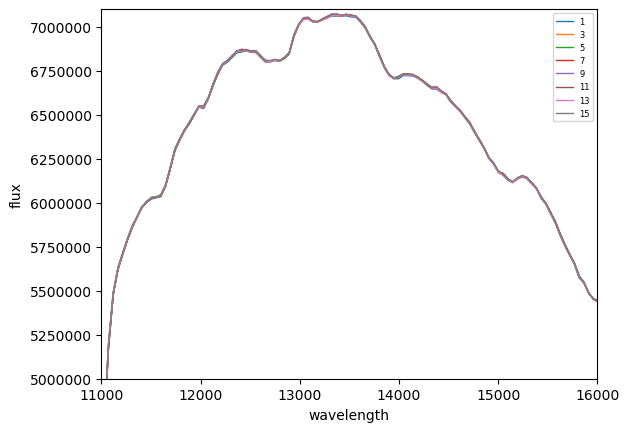

In [15]:
for img in range(spec_o2.shape[0]):
    if (img % 2 == 0):
        continue
    plt.plot(wavs_o3, spec_o3[img], lw=1, label=img)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.xlim((11000, 16000))
plt.ylim((5e6, 7.1e6))
plt.legend(loc='best', fontsize=6)
plt.show()

In [16]:
testidxs = np.where((wavs_o3 >= 11000) & (wavs_o3 <= 16000))[0]
meandiff = abs(np.mean(spec_o3[2][testidxs] - spec_o3[0][testidxs]))
print('Mean difference = ', meandiff)
pe = (meandiff / np.mean(spec_o3[2][testidxs]))
print('Which is %.4f percent of average spectrum flux'%(pe))

Mean difference =  3219.9503149940956
Which is 0.0005 percent of average spectrum flux


In [17]:
spec_o3.shape

(17, 181)

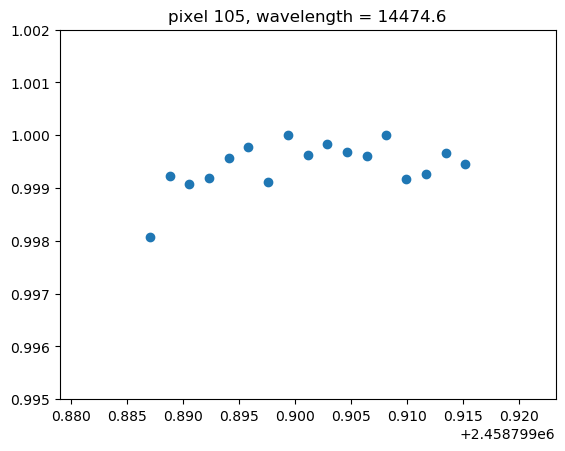

In [18]:
pix = 105
pix_lc = np.copy(spec_o3[:,pix])
pnormval1 = np.max(pix_lc[::2])
pix_lc[::2] /= pnormval1
pnormval2 = np.max(pix_lc[1::2])
pix_lc[1::2] /= pnormval2
plt.scatter(time_o3, pix_lc)
plt.ylim((0.995, 1.002))
plt.title('pixel %d, wavelength = %.1f'%(pix, wavs_o3[pix]))
plt.show()

In [19]:
meandiff

3219.9503149940956

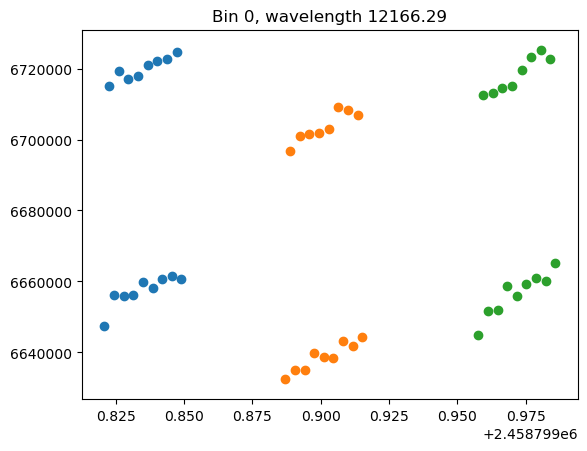

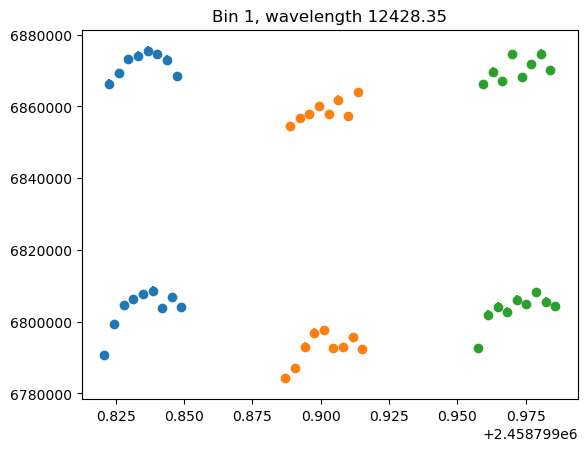

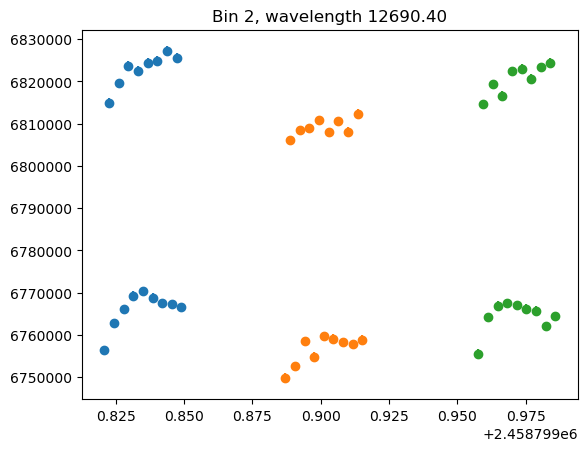

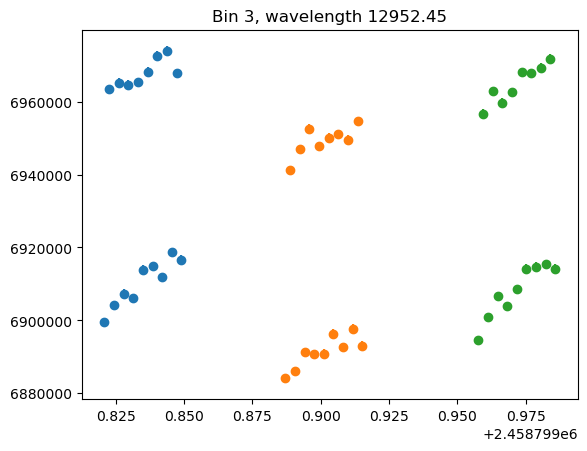

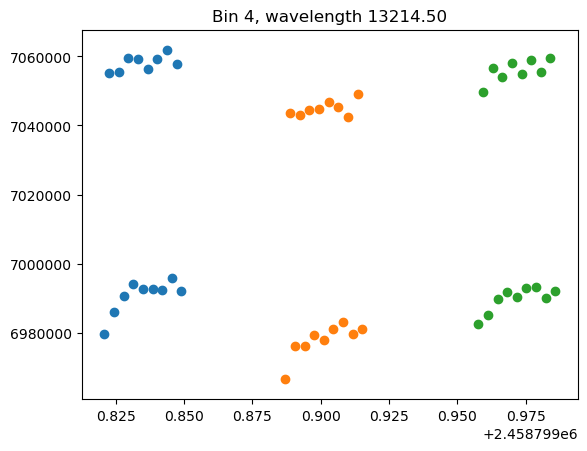

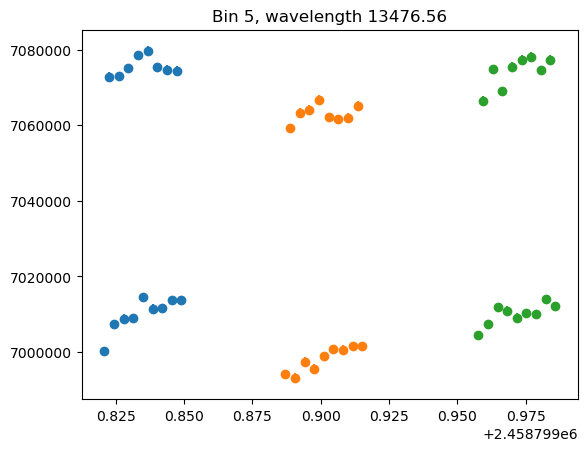

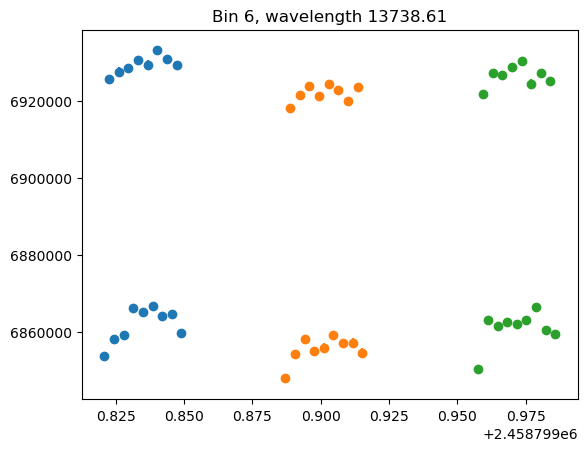

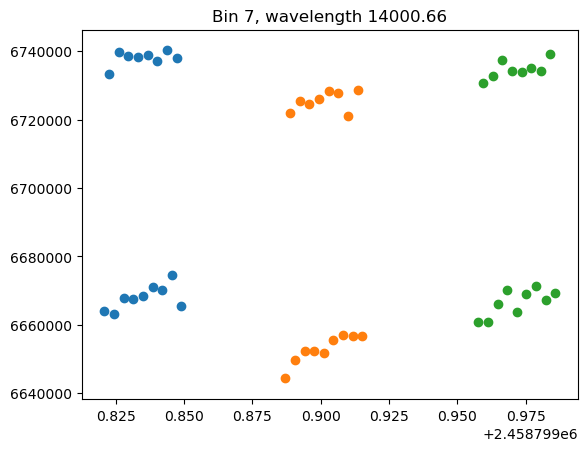

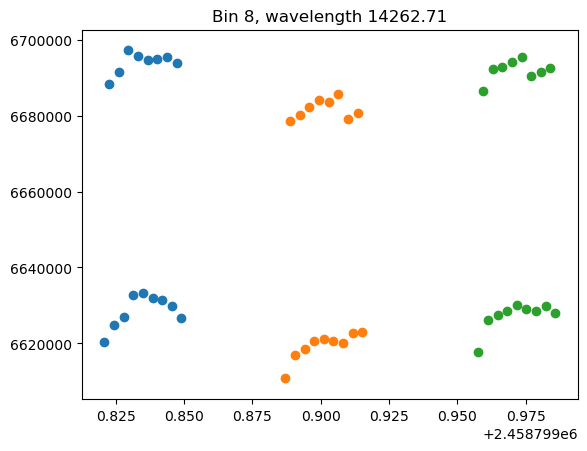

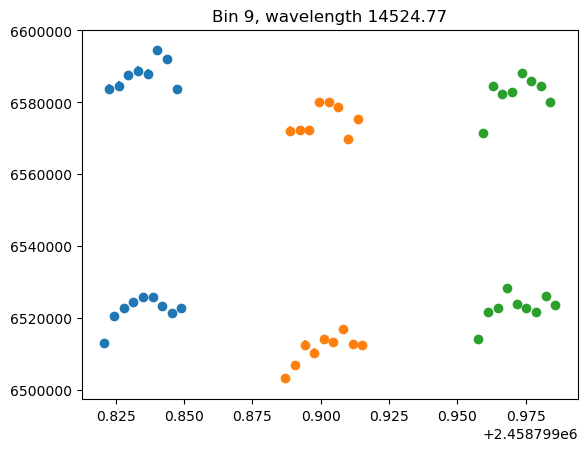

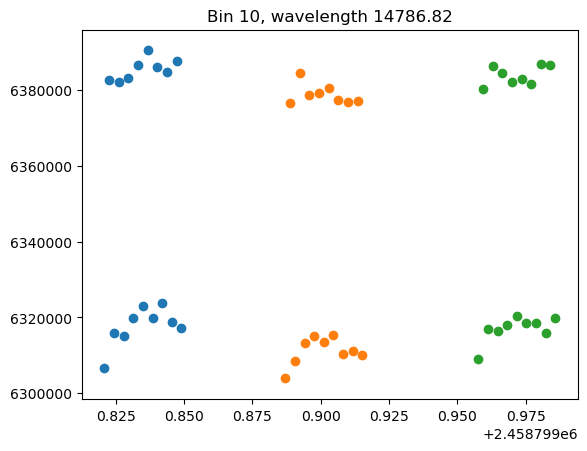

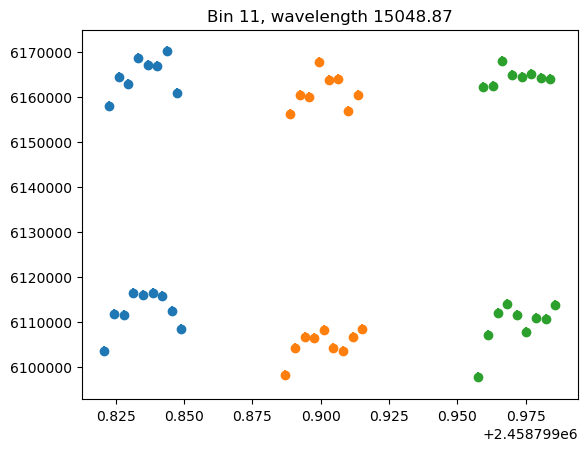

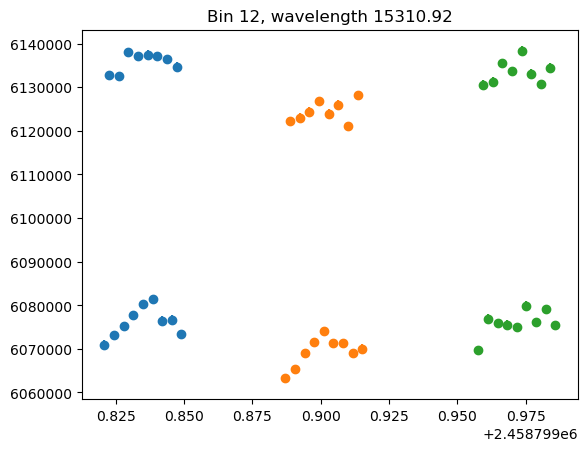

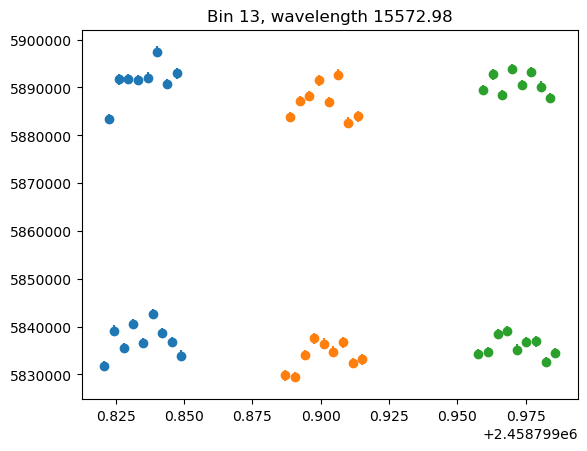

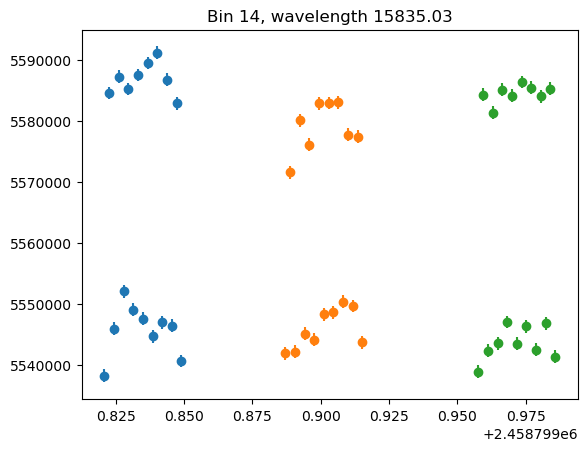

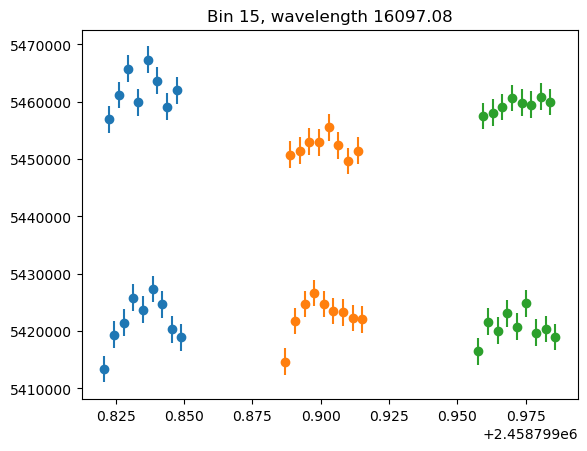

In [20]:
for i in range(binnedspec_o2.shape[1]):
    plt.title('Bin %d, wavelength %.2f'%(i, binnedwavs_o2[i]))
    plt.errorbar(time_o2, binnedspec_o2[:,i], binnederrs_o2[:,i], ls='None', marker='o')
    plt.errorbar(time_o3, binnedspec_o3[:,i], binnederrs_o3[:,i], ls='None', marker='o')
    plt.errorbar(time_o4, binnedspec_o4[:,i], binnederrs_o4[:,i], ls='None', marker='o')
    plt.show()

In [21]:
normspec_o2, normerrs_o2 = np.copy(binnedspec_o2), np.copy(binnederrs_o2)
normspec_o3, normerrs_o3 = np.copy(binnedspec_o3), np.copy(binnederrs_o3)
normspec_o4, normerrs_o4 = np.copy(binnedspec_o4), np.copy(binnederrs_o4)
for wav in range(Nbins):
    normval1 = np.max(binnedspec_o2[:,wav][::2])
    normval2 = np.max(binnedspec_o2[:,wav][1::2])
    
    normspec_o2[:,wav][::2] /= normval1
    normspec_o2[:,wav][1::2] /= normval2
    normerrs_o2[:,wav][::2] /= normval1
    normerrs_o2[:,wav][1::2] /= normval2
    
    normspec_o3[:,wav][::2] /= normval1
    normspec_o3[:,wav][1::2] /= normval2
    normerrs_o3[:,wav][::2] /= normval1
    normerrs_o3[:,wav][1::2] /= normval2    
    
    normspec_o4[:,wav][::2] /= normval1
    normspec_o4[:,wav][1::2] /= normval2
    normerrs_o4[:,wav][::2] /= normval1
    normerrs_o4[:,wav][1::2] /= normval2    

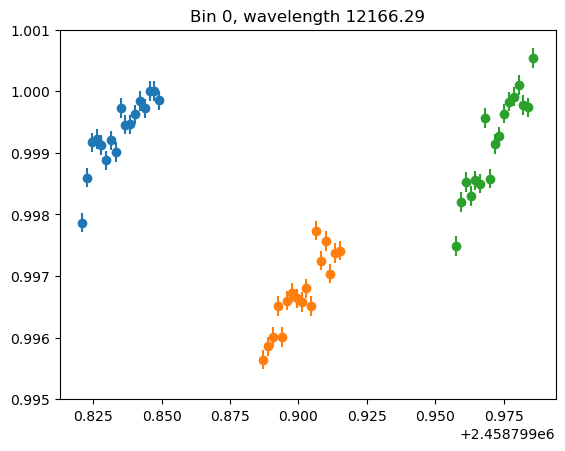

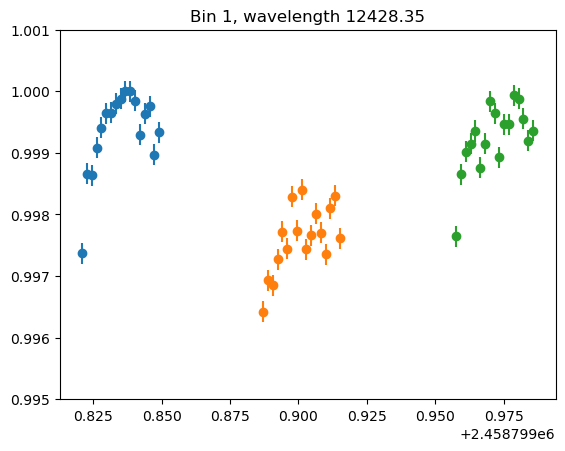

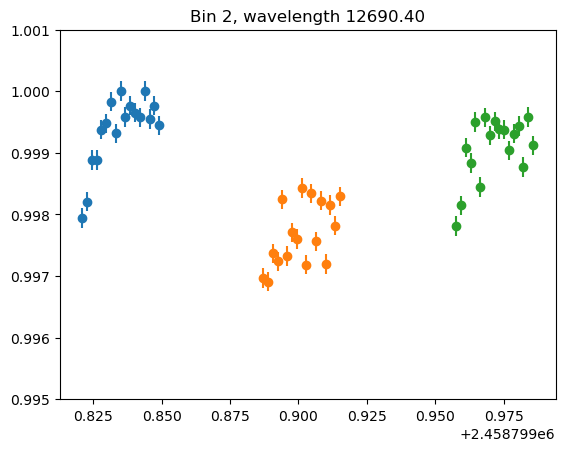

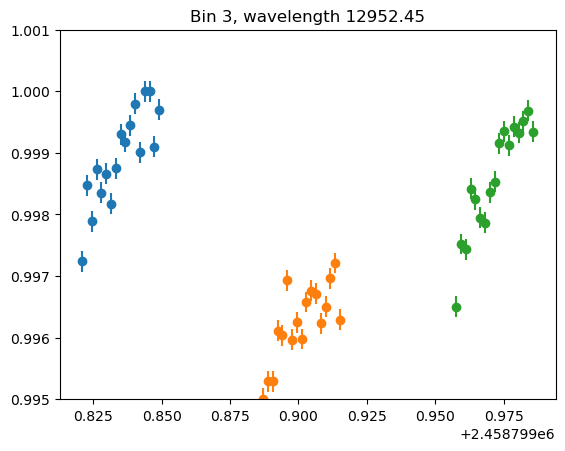

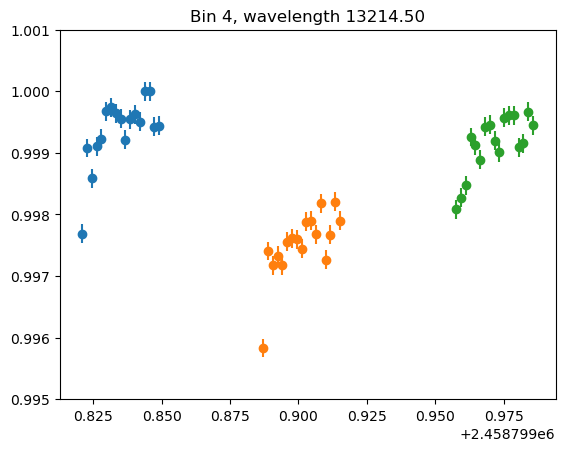

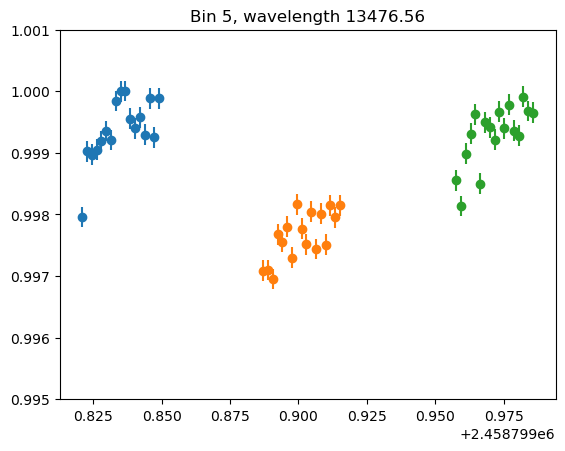

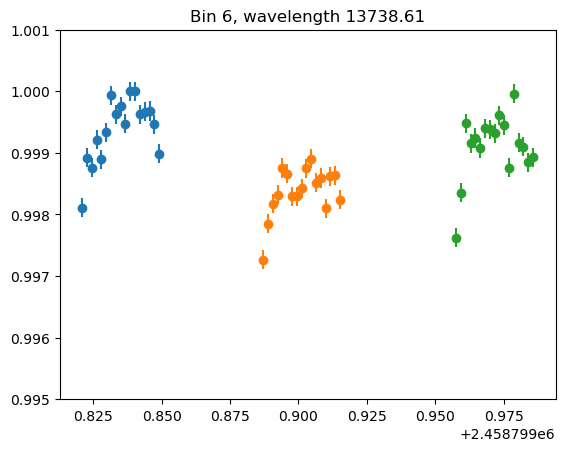

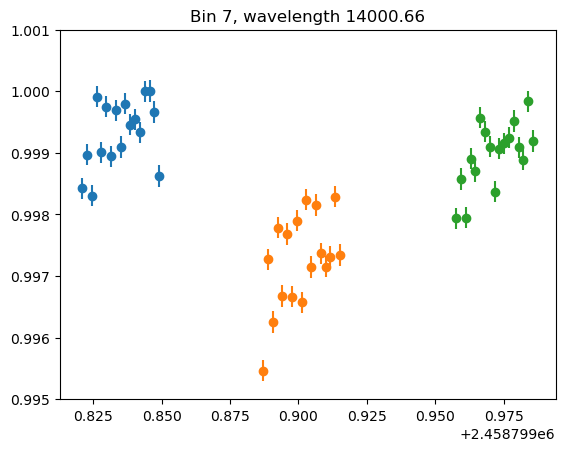

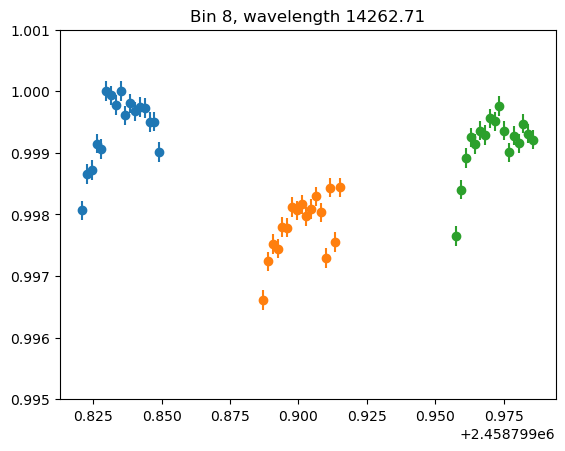

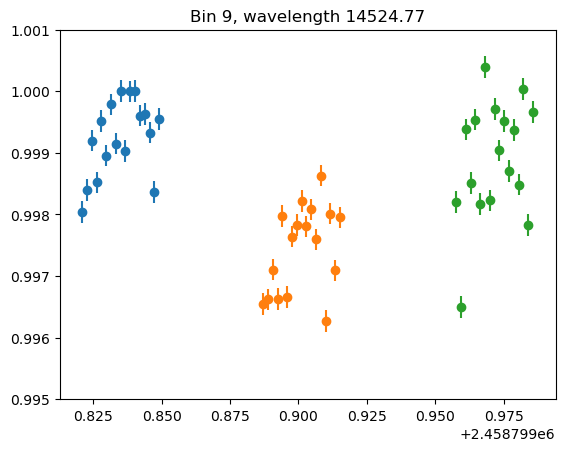

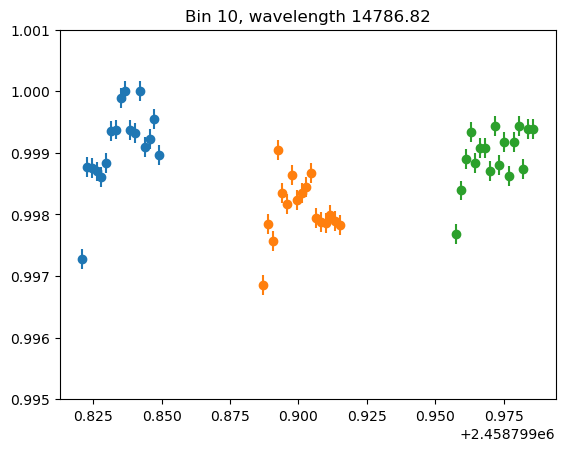

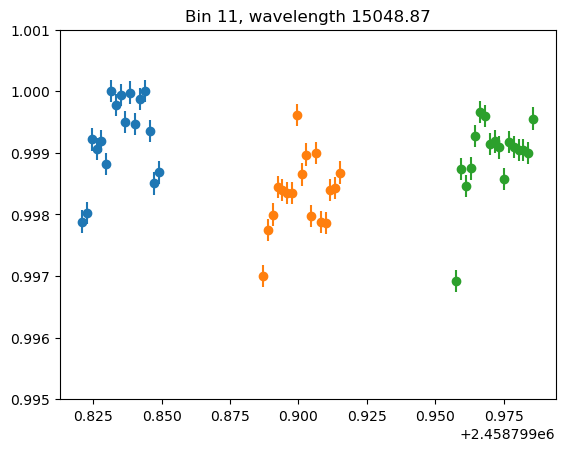

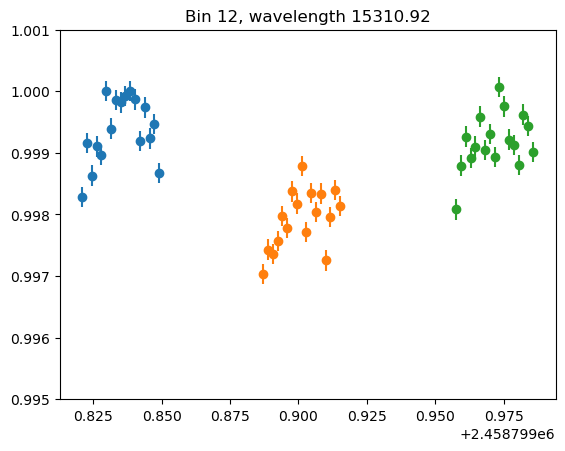

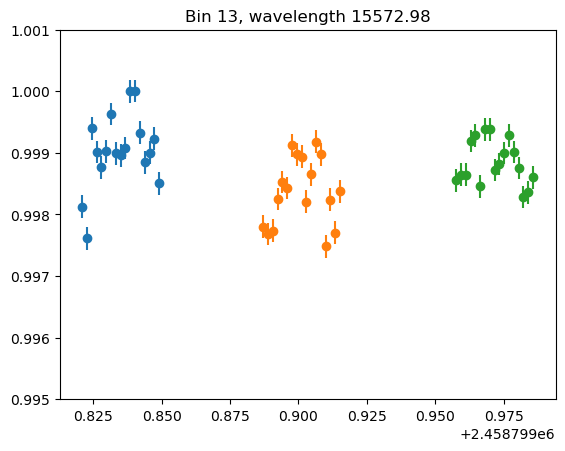

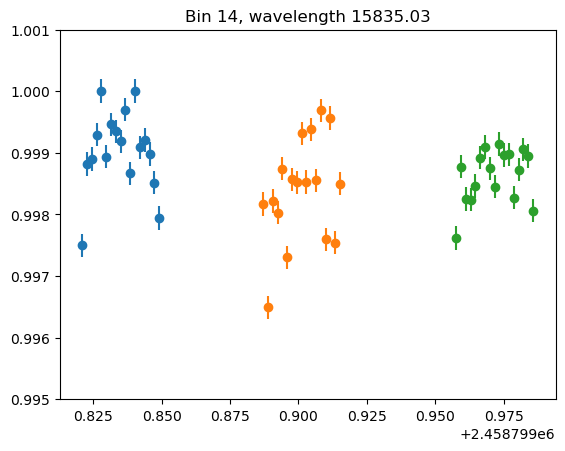

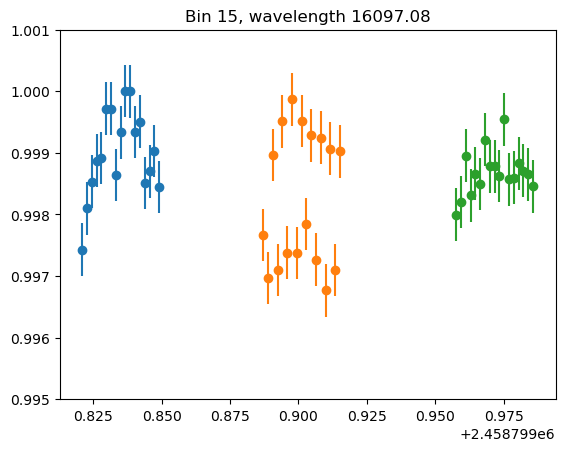

In [22]:
for i in range(normspec_o2.shape[1]):
    plt.title('Bin %d, wavelength %.2f'%(i, binnedwavs_o2[i]))
    plt.errorbar(time_o2, normspec_o2[:,i], normerrs_o2[:,i], ls='None', marker='o')
    plt.errorbar(time_o3, normspec_o3[:,i], normerrs_o3[:,i], ls='None', marker='o')
    plt.errorbar(time_o4, normspec_o4[:,i], normerrs_o4[:,i], ls='None', marker='o')
    plt.ylim((0.995, 1.001))
    plt.show()

In [23]:
o3meds = np.zeros(Nbins)
for wav in range(Nbins):
    o3meds[wav] = np.median(normspec_o3[:,wav])

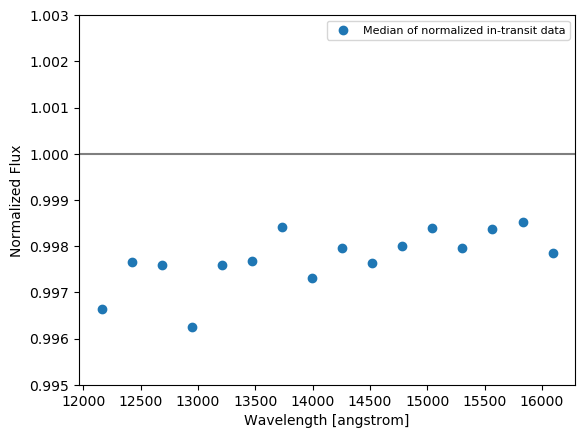

In [24]:
plt.scatter(binnedwavs_o3, o3meds, label='Median of normalized in-transit data')
plt.ylim((0.995, 1.003))
plt.axhline(1., c='black', alpha=0.5)
plt.xlabel('Wavelength [angstrom]')
plt.ylabel('Normalized Flux')
plt.legend(loc='best', fontsize=8)
plt.show()

Combining and saving the spectral time-series...

In [25]:
times = np.concatenate((time_o2, time_o3, time_o4))
fluxes = np.concatenate((normspec_o2, normspec_o3, normspec_o4), axis=0)
errors = np.concatenate((normerrs_o2, normerrs_o3, normerrs_o4), axis=0)
waves = np.copy(binnedwavs_o2)

In [26]:
saveDat = False
if saveDat:
    path = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(path+'normalizedSpectralTimeSeries.npz', 
            times=times, fluxes=fluxes, errors=errors, wavelengths=waves)
    print('Saved to path ', path)